
# Mini-projet de séparation de sources audio
### I&I Apprentissage profond et traitement du signal, MVA


- *Lorenzo Brucato - auditeur externe, M2 Mathématiques et intelligence artificielle, Université Paris-Saclay & CentraleSupélec*

- *Mohamed Amir Belkacem - Telecom Paris & ENS Saclay, Mathématiques Vision Apprentissage* 

L'objectif de ce mini-projet est d'implémenter, d'entrainer et de comparer diverses architectures de réseaux de neurones profonds pour la séparation de sources audio : nous possédons un jeu de données composé de 4000 échantillons d'audio pour l'entrainement avec une partie vocale qui interfère avec un bruit de fond sonore (donnée d'entrée) et les composantes vocale et de bruit réelles (sources cibles). L'objectif est d'extraire séparemment à partir des deux sources chacune de ces deux sources, en obtenant un signal sonore composé uniquement de la partie vocale et un signal sonore ne contenant que le bruit de fond.

Pour chacun des audios, le SNR (signal to noise ratio) indique le niveau de puissance de l'une des sources par rapport à l'autre (de -4dB lorsque le bruit est supérieur de 4dB à la composante vocale, 0dB pour l'équilibre des deux sources et jusqu'à 4dB lorsque la composante vocale prend l'avantage sur le bruit de fond)

Pour chacune des architectures analysées, nous verrons l'approche mise en place (passage par une représentation temps/fréquence du signal ou non, utilisation de la forme d'onde, architecture de convolution/déconvolution ou réseaux de neurones récurrents...) et écouterons la qualité de l'audio extrait.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import mir_eval
from torchsummary import summary
import torchaudio
import IPython

from Datasets.Audiodata import *
from Models.UNet import *
from Models.UNet2 import * 
from Models.WaveUNet import *
from Models.TasNet import *

In [5]:
import warnings
warnings.filterwarnings('ignore')

___
### 1. Chargement des données et visualisation

*Chargement du dataset :*

In [8]:
dataset = Audiodataset(set='train_small')
print(len(dataset))

50


*Forme d'onde :*

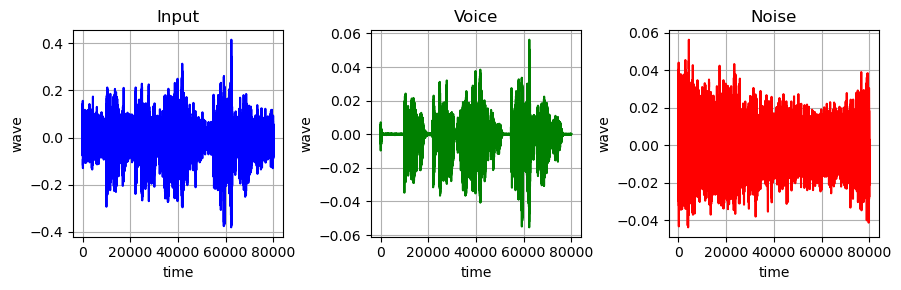

In [10]:
dataset.take_wave()
dataset.plot(0)

*Représentation temps/fréquence :*

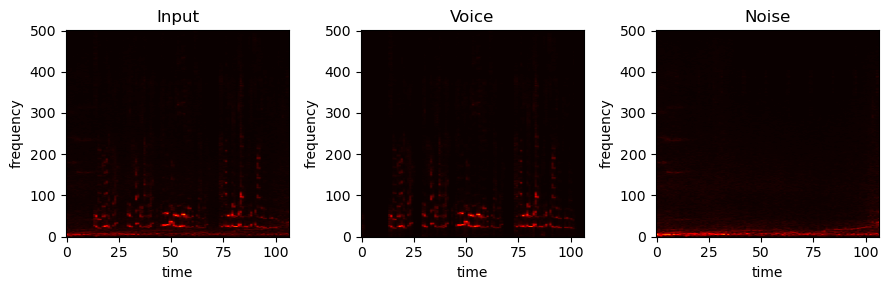

In [16]:
dataset.take_spectrogram()
dataset.plot(0)
plt.savefig('Figs/sp.png')

*Reconstruction du son depuis la représentation temps/fréquence (istft) :*

In [19]:
idx = 0
sr = 8000

dataset = Audiodataset('test', padding=True)
dataset.return_only_voice()
dataset.take_spectrogram()
X, VoiceSP = dataset[idx]

reconstruct = dataset.reconstruct(VoiceSP, idx, reference='voice')
IPython.display.Audio(reconstruct.squeeze().numpy(), rate=sr)

*Distribution de la répartition des sons selon leur snr de base :*

In [22]:
snr_sum = []
for snr in range(-4, 5):
    snr_sum.append(len(Audiodataset('train', snr_filter=snr)))

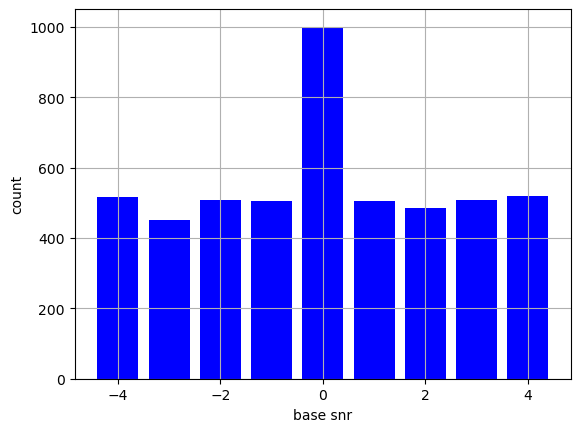

In [23]:
plt.bar(range(-4, 5), snr_sum, color='blue')
plt.xlabel('base snr')
plt.ylabel('count')
plt.grid()

___
### 2. UNet à un seul canal de sortie

Dans cette partie on implémente et visualise les résultats obtenus par UNet sur la représentation temps/fréquence du modèle tel que décris par Jansson et al. (2017) https://archives.ismir.net/ismir2017/paper/000171.pdf. L'architecture comprend trois phases : 
- Le passage de la donnée initiale dans le domaine temps fréquence par transformation de fourier
- L'entrainement d'un réseau de neurones profond par architecture UNet apprenant à générer un masque appliqué à la représentation pour extraire les deux sources du signal
- La reconstruction du signal ensuite à partir de la phase de la donnée initiale par transformée de fourrier inverse (istft)

Pour s'adapter aux dimensions de l'article et faciliter les dimensions obtenues par convolutions successives, on réalise également un padding sur les images temps/fréquence.

*Détail des dimensions sur les couches du réseau :*

In [29]:
model = UNet().to(device)
summary(model, input_size = (1,512,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 256, 64]             416
       BatchNorm2d-2          [-1, 16, 256, 64]              32
         LeakyReLU-3          [-1, 16, 256, 64]               0
       EncodeBlock-4          [-1, 16, 256, 64]               0
            Conv2d-5          [-1, 32, 128, 32]          12,832
       BatchNorm2d-6          [-1, 32, 128, 32]              64
         LeakyReLU-7          [-1, 32, 128, 32]               0
       EncodeBlock-8          [-1, 32, 128, 32]               0
            Conv2d-9           [-1, 64, 64, 16]          51,264
      BatchNorm2d-10           [-1, 64, 64, 16]             128
        LeakyReLU-11           [-1, 64, 64, 16]               0
      EncodeBlock-12           [-1, 64, 64, 16]               0
           Conv2d-13           [-1, 128, 32, 8]         204,928
      BatchNorm2d-14           [-1, 128

*Nombre de paramètres : ~9.82M*

In [32]:
print(np.sum([p.numel() for p in model.parameters()]))

9823317


#### -- Modèle pour la composante vocale --

*Données pour l'entrainement du modèle :*

In [36]:
voice_train_dataset = Audiodataset('train', padding = True,  getitem='voice')
voice_train_dataset.take_spectrogram()

voice_test_dataset = Audiodataset('test', padding = True,getitem='voice')
voice_test_dataset.take_spectrogram()

*Entrainement :*

In [39]:
# ==== Entrainement du modèle ====
# voice_model, voice_losses = UNet.trainModel(voice_train_dataset, data_type='Voice', n_epochs=40, batch_size=16, learning_rate=0.001, valid_dataset=voice_test_dataset, schedule = True)

*Evolution de la loss* :

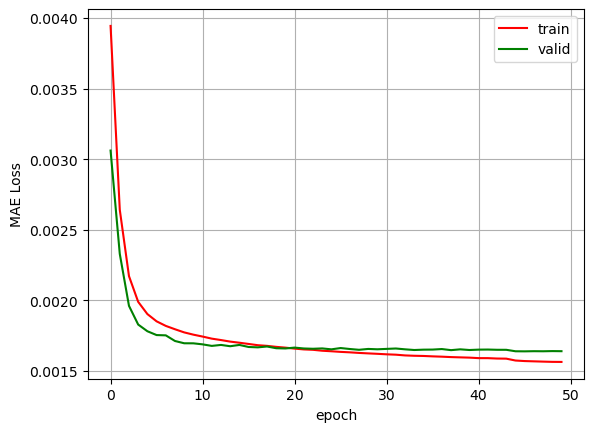

In [42]:
voice_scores_UNet = pd.read_csv('Scores/UNet/Voice/UNetMAE.csv')
voice_train_error = voice_scores_UNet['train']
voice_valid_error = voice_scores_UNet['valid']

plt.plot(voice_train_error, color='red', label='train')
plt.plot(voice_valid_error, color='green', label='valid')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MAE Loss')
plt.savefig('Figs/UNet_voice_loss.png')

*Analyse de la qualité sonore :*

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
voice_model = UNet().to(device)
voice_model.load_state_dict(torch.load('Paths/UNet/Voice/model_50.pth', map_location=device))

# échantillon de test
idx = 0

*Masque généré pour une donnée test :*

In [48]:
X, Y = voice_test_dataset[idx]
X_ = X.unsqueeze(0).unsqueeze(0).to(device)
output = voice_model(X_)

(512, 128) (512, 128)


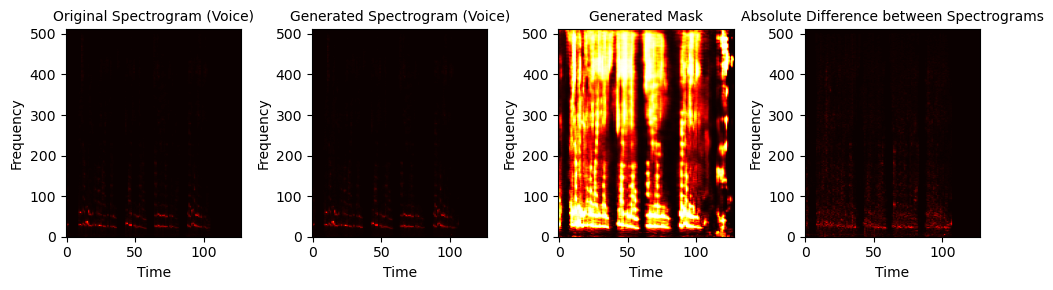

In [50]:
pred = output * X_

Vtrue = Y.detach().cpu().numpy()  # Move to CPU before converting to NumPy
Vpred = (pred).squeeze().detach().cpu().numpy()  # Move to CPU before converting to NumPy
mask = output.squeeze().detach().cpu().numpy()
mix = X.squeeze().detach().cpu().numpy()

print(Vpred.shape, Vtrue.shape)

fig, axs = plt.subplots(1, 4, figsize=(10, 3))

axs[0].imshow(Vtrue, aspect='auto', origin='lower', cmap='hot')
axs[0].set_title('Original Spectrogram (Voice)', fontsize=10)  # Reduce title size
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Frequency')

axs[1].imshow(Vpred, aspect='auto', origin='lower', cmap='hot')
axs[1].set_title('Generated Spectrogram (Voice)', fontsize=10)  # Reduce title size
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Frequency')

axs[2].imshow(mask, aspect='auto', origin='lower', cmap='hot')
axs[2].set_title('Generated Mask', fontsize=10)  # Reduce title size
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Frequency')

axs[3].imshow(np.abs(Vpred - Vtrue), aspect='auto', origin='lower', cmap='hot')
axs[3].set_title('Absolute Difference between Spectrograms', fontsize=10)  # Reduce title size
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('Figs/UNet_voice_sp.png')
plt.show()

In [52]:
np.sum(np.abs(Vtrue-Vpred))

107.16727

*Comparaison voix originale, voix générée :*

In [55]:
reconstructed_true = voice_test_dataset.reconstruct(Y, id0=idx, reference='voice')
IPython.display.Audio(reconstructed_true.detach().numpy(), rate=8000)

In [57]:
reconstructed_output = voice_test_dataset.reconstruct(pred.cpu(), id0=idx, reference='input')
IPython.display.Audio(reconstructed_output.detach().numpy(), rate=8000)

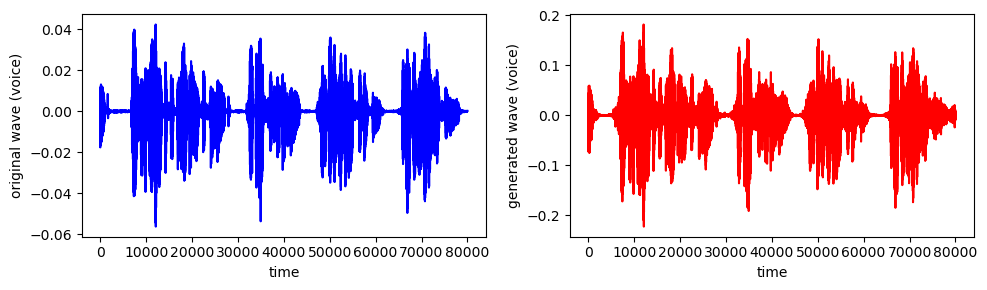

In [59]:
S_true = reconstructed_true.squeeze().detach().numpy()
S_pred = reconstructed_output.squeeze().detach().numpy()
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(S_true, color='blue')
axs[0].set_xlabel('time')
axs[0].set_ylabel('original wave (voice)')

axs[1].plot(S_pred, color='red')
axs[1].set_xlabel('time')
axs[1].set_ylabel('generated wave (voice)')
plt.savefig('Figs/UNet_voice_wave.png')

plt.tight_layout()

#### -- Modèle pour la composante de fond sonore --

*Données pour l'entraînement du modèle :*

In [63]:
noise_train_dataset = Audiodataset('train',padding = True,  getitem='noise')
noise_train_dataset.take_spectrogram()

noise_test_dataset = Audiodataset('test', padding = True,getitem='noise')
noise_test_dataset.take_spectrogram()

*Entraînement :*

In [66]:
# === Entrainement ===
# noise_model, noise_losses = UNet.trainModel(noise_train_dataset, data_type='Noise', n_epochs=50, batch_size=16, learning_rate=0.001, valid_dataset=noise_test_dataset, schedule = True)

*Evolution de la loss :*

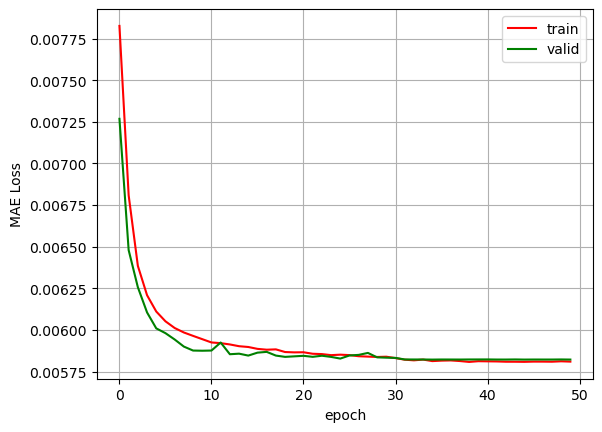

In [69]:
noise_scores_UNet = pd.read_csv('Scores/UNet/Noise/UNetMAE.csv')
noise_train_error = noise_scores_UNet['train']
noise_valid_error = noise_scores_UNet['valid']

plt.plot(noise_train_error, color='red', label='train')
plt.plot(noise_valid_error, color='green', label='valid')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MAE Loss')
plt.savefig('Figs/UNet_noise_loss.png')

*Analyse de la qualité sonore sur une donnée test :*

In [72]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
noise_model = UNet().to(device)
noise_model.load_state_dict(torch.load('Paths/UNet/Noise/model_50.pth', map_location=device))

# échantillon test
idx = 0

*Visulasiation du masque généré :*

(512, 128) (512, 128)


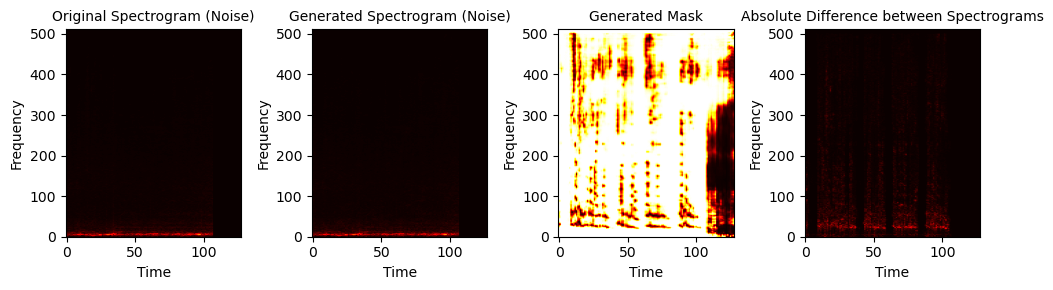

In [75]:
X, Y = noise_test_dataset[idx]
X_ = X.unsqueeze(0).unsqueeze(0).to(device)
output = noise_model(X_)

pred = output * X_

Vtrue = Y.detach().cpu().numpy()  # Move to CPU before converting to NumPy
Vpred = (pred).squeeze().detach().cpu().numpy()  # Move to CPU before converting to NumPy
mask = output.squeeze().detach().cpu().numpy()

print(Vpred.shape, Vtrue.shape)

fig, axs = plt.subplots(1, 4, figsize=(10, 3))

axs[0].imshow(Vtrue, aspect='auto', origin='lower', cmap='hot')
axs[0].set_title('Original Spectrogram (Noise)', fontsize=10)  # Reduce title size
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Frequency')

axs[1].imshow(Vpred, aspect='auto', origin='lower', cmap='hot')
axs[1].set_title('Generated Spectrogram (Noise)', fontsize=10)  # Reduce title size
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Frequency')

axs[2].imshow(mask, aspect='auto', origin='lower', cmap='hot')
axs[2].set_title('Generated Mask', fontsize=10)  # Reduce title size
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Frequency')

axs[3].imshow(np.abs(Vpred - Vtrue), aspect='auto', origin='lower', cmap='hot')
axs[3].set_title('Absolute Difference between Spectrograms', fontsize=10)  # Reduce title size
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('Figs/UNet_noise_sp.png')

plt.show()

In [77]:
np.sum(np.abs(Vtrue-Vpred))

95.054085

*Comparaison qualitative son original/son généré :*

In [80]:
reconstructed_true = noise_test_dataset.reconstruct(Y, id0=idx, reference = 'noise')
IPython.display.Audio(reconstructed_true.detach().numpy(), rate=8000)

In [82]:
reconstructed_output = noise_test_dataset.reconstruct(pred.cpu(), id0=idx, reference='input')
IPython.display.Audio(reconstructed_output.detach().numpy(), rate=8000)

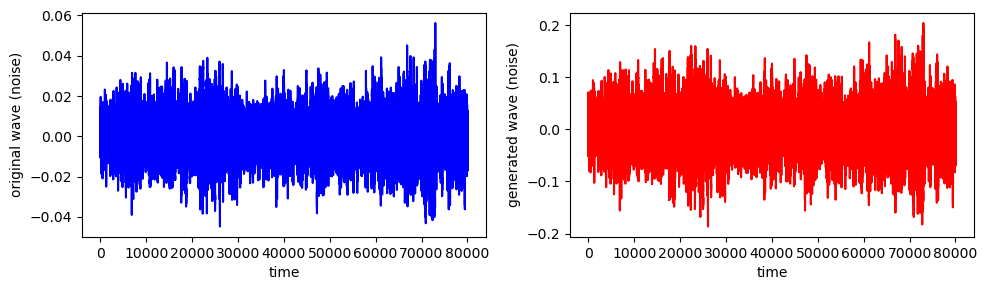

In [84]:
S_true = reconstructed_true.squeeze().detach().numpy()
S_pred = reconstructed_output.squeeze().detach().numpy()
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(S_true, color='blue')
axs[0].set_xlabel('time')
axs[0].set_ylabel('original wave (noise)')

axs[1].plot(S_pred, color='red')
axs[1].set_xlabel('time')
axs[1].set_ylabel('generated wave (noise)')
plt.savefig('Figs/UNet_noise_wave.png')

plt.tight_layout()

#### -- Comparaison des résultats par SNR de base --- 

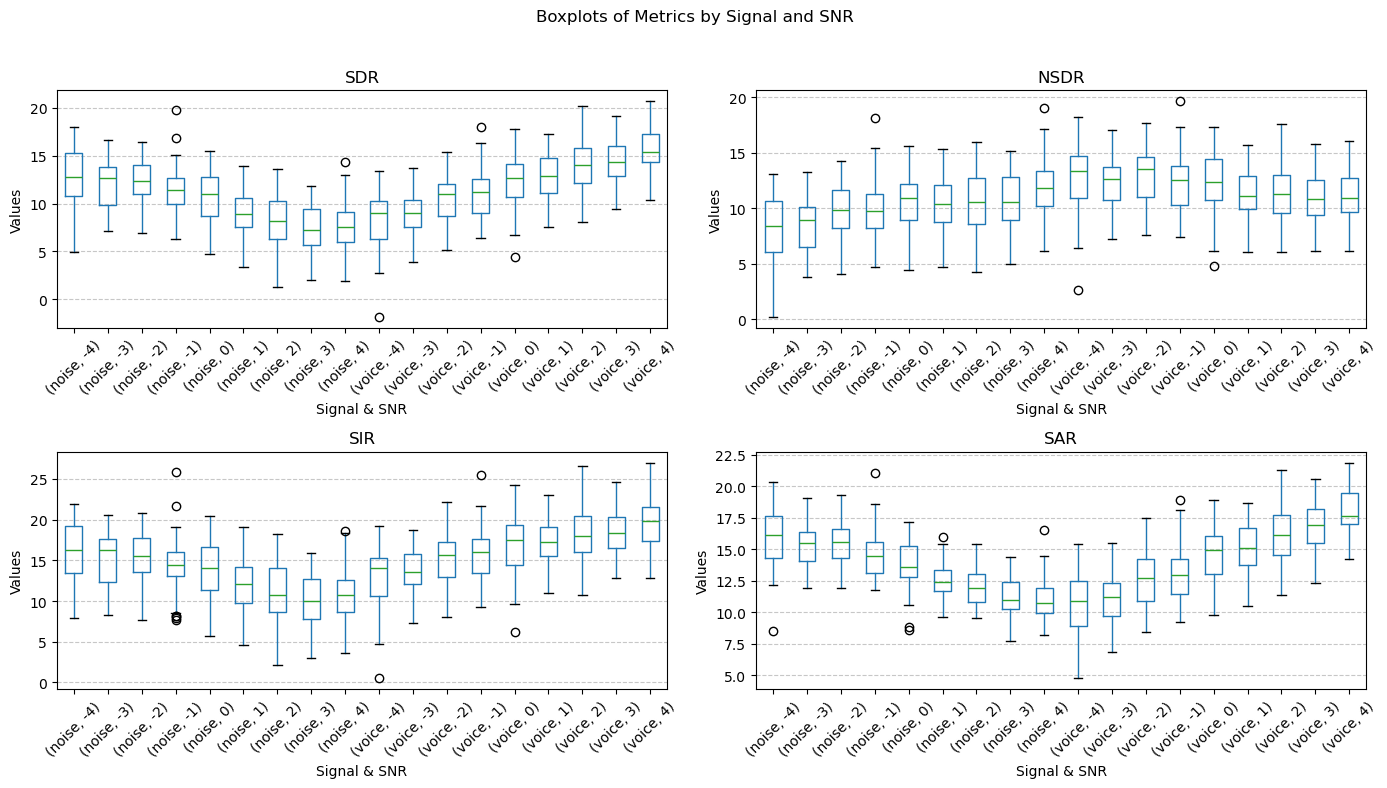

In [87]:
metrics_dir = "Scores/UNet/"

metrics_by_snr = {}

# Liste des SNR et des signaux que vous avez enregistrés
snr_values = np.arange(-4,5)  
signals = ['voice', 'noise']  

# Lire les fichiers CSV pour chaque combinaison SNR et Signal
for snr in snr_values:
    metrics_by_snr[snr] = {}  
    for signal in signals:
        # Construire le chemin du fichier correspondant pour ce signal et SNR
        file_path = os.path.join(metrics_dir, f'val_metrics_SNR_{snr}_{signal}.csv')
        if os.path.exists(file_path):
            #print(file_path)
            # Lire le fichier CSV dans un DataFrame
            df = pd.read_csv(file_path)
            
            # Stocker les métriques pour ce signal et SNR
            metrics_by_snr[snr][signal] = df

# Combiner les données pour chaque signal et SNR
all_data = []
for snr, metrics in metrics_by_snr.items():
    for signal, df in metrics.items():
        df['SNR'] = snr
        df['Signal'] = signal
        all_data.append(df)

# Créer un DataFrame combiné
combined_df = pd.concat(all_data, ignore_index=True)

# Tracer les boxplots pour chaque métrique
metrics = ['SDR', 'NSDR', 'SIR', 'SAR']
plt.figure(figsize=(14, 8))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    combined_df.boxplot(column=metric, by=['Signal', 'SNR'], grid=False, ax=plt.gca())
    plt.title(metric)
    plt.xlabel('Signal & SNR')
    plt.ylabel('Values')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajouter un titre principal et ajuster la mise en page
plt.suptitle('Boxplots of Metrics by Signal and SNR')
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Sauvegarder le graphique
output_path = 'Figs/UNet_val_metrics.png'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path)

# Afficher le graphique
plt.show()

___
### 3. UNet à deux canaux de sortie

Au lieu d'entrainer deux modèles qui apprennent à générer les deux sources distinctes, l'architecture ci-dessous génère les deux masques simultanément sur deux canaux distincts en sortie du réseau en s'inspirant du modèle WaveUNet. Cela permet d'entrainer le modèle sur la même base de paramètres : on analyse l'efficicacité de ce modèle sur nos données.

*Description des dimensions sur les couches du réseau de neurones :*

In [92]:
model = UNet2().to(device)
summary(model, input_size = (1,512,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 256, 64]             416
       BatchNorm2d-2          [-1, 16, 256, 64]              32
         LeakyReLU-3          [-1, 16, 256, 64]               0
       EncodeBlock-4          [-1, 16, 256, 64]               0
            Conv2d-5          [-1, 32, 128, 32]          12,832
       BatchNorm2d-6          [-1, 32, 128, 32]              64
         LeakyReLU-7          [-1, 32, 128, 32]               0
       EncodeBlock-8          [-1, 32, 128, 32]               0
            Conv2d-9           [-1, 64, 64, 16]          51,264
      BatchNorm2d-10           [-1, 64, 64, 16]             128
        LeakyReLU-11           [-1, 64, 64, 16]               0
      EncodeBlock-12           [-1, 64, 64, 16]               0
           Conv2d-13           [-1, 128, 32, 8]         204,928
      BatchNorm2d-14           [-1, 128

*Nombre de paramètres : ~39.3M (couches supplémentaires ajoutées par rapport au UNet)*

In [95]:
np.sum([p.numel() for p in model.parameters()])

39319932

*Chargement des données pour l'entrainement du UNet2 :*

In [98]:
train_dataset = Audiodataset('train',  padding=True, getitem='all')
train_dataset.take_spectrogram()

test_dataset = Audiodataset('test', padding=True, getitem='all')
test_dataset.take_spectrogram()

*Entrainement :*

In [101]:
# ==== Entrainement +20 epochs ====
# model, losses = UNet2.trainModel(train_dataset, n_epochs=30, batch_size=16, learning_rate=0.0001, valid_dataset=test_dataset)

*Evolution de la fonction de perte :*

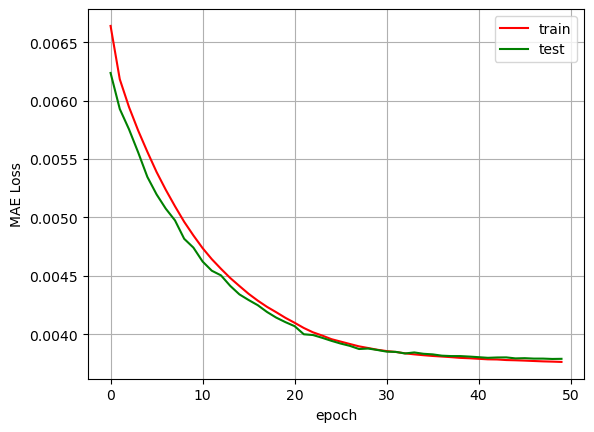

In [104]:
scores_WaveUNet = pd.read_csv('Scores/UNet2/UNet2MAE.csv')
train_error = scores_WaveUNet['train']
valid_error = scores_WaveUNet['valid']
plt.plot(train_error, color='red', label='train')
plt.plot(valid_error, color='green', label='test')

plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MAE Loss')
plt.savefig('Figs/UNet2_loss.png')

*Visualisation d'un masque estimé et écoute de la qualité audio :*

In [107]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet2().to(device)
model.load_state_dict(torch.load('Paths/UNet2/model_50.pth', map_location=device))

idx = 0

(2, 512, 128) (2, 512, 128)


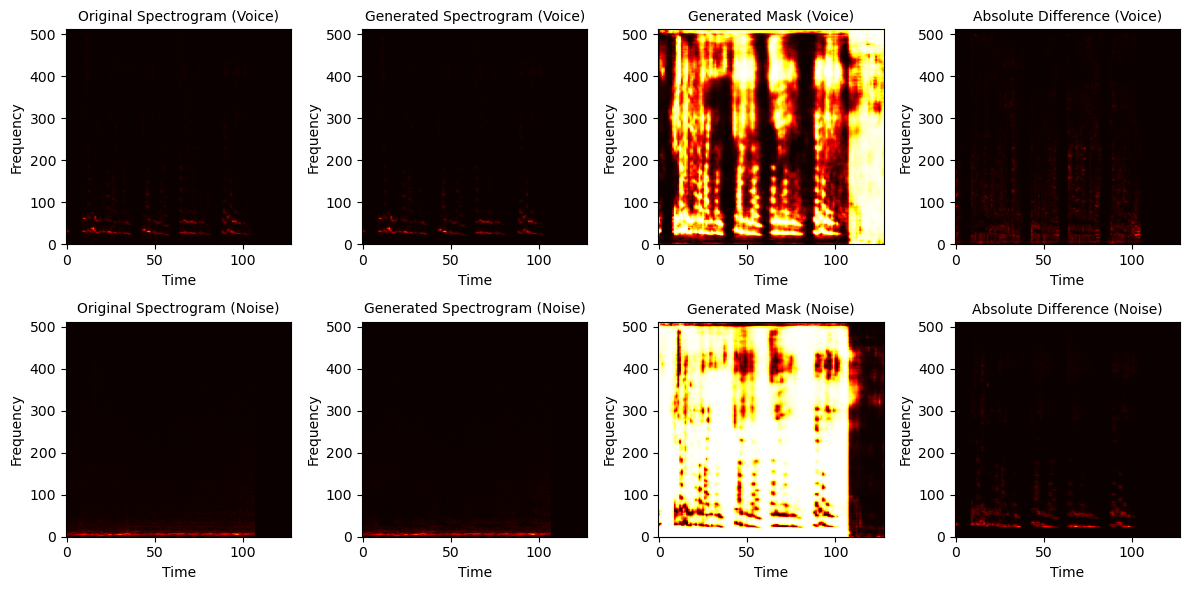

In [109]:
X, voice,noise, _, _ = test_dataset[idx]
output = model(X.unsqueeze(0).unsqueeze(0).to(device)).squeeze()
voice_ = voice.unsqueeze(0)
noise_ = noise.unsqueeze(0)
Y = torch.cat((voice_, noise_), dim=0).to(device)  # Concatenate along the channel dimension

pred = output * Y

Vpred = (pred).squeeze().detach().cpu().numpy()  
mask = output.squeeze().detach().cpu().numpy()
voice_ = voice_.squeeze().detach().cpu().numpy()
noise_ = noise_.squeeze().detach().cpu().numpy()
print(Vpred.shape, mask.shape)

fig, axs = plt.subplots(2, 4, figsize=(12, 6)) 

axs[0, 0].imshow(voice_, aspect='auto', origin='lower', cmap='hot')
axs[0, 0].set_title('Original Spectrogram (Voice)', fontsize=10)
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Frequency')

axs[0, 1].imshow(Vpred[0], aspect='auto', origin='lower', cmap='hot')
axs[0, 1].set_title('Generated Spectrogram (Voice)', fontsize=10)
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Frequency')

axs[0, 2].imshow(mask[0], aspect='auto', origin='lower', cmap='hot')
axs[0, 2].set_title('Generated Mask (Voice)', fontsize=10)
axs[0, 2].set_xlabel('Time')
axs[0, 2].set_ylabel('Frequency')

axs[0, 3].imshow(np.abs(Vpred[0] - voice_), aspect='auto', origin='lower', cmap='hot')
axs[0, 3].set_title('Absolute Difference (Voice)', fontsize=10)
axs[0, 3].set_xlabel('Time')
axs[0, 3].set_ylabel('Frequency')

axs[1, 0].imshow(noise_, aspect='auto', origin='lower', cmap='hot')
axs[1, 0].set_title('Original Spectrogram (Noise)', fontsize=10)
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Frequency')

axs[1, 1].imshow(Vpred[1], aspect='auto', origin='lower', cmap='hot')
axs[1, 1].set_title('Generated Spectrogram (Noise)', fontsize=10)
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Frequency')

axs[1, 2].imshow(mask[1], aspect='auto', origin='lower', cmap='hot')
axs[1, 2].set_title('Generated Mask (Noise)', fontsize=10)
axs[1, 2].set_xlabel('Time')
axs[1, 2].set_ylabel('Frequency')

axs[1, 3].imshow(np.abs(Vpred[1] - noise_), aspect='auto', origin='lower', cmap='hot')
axs[1, 3].set_title('Absolute Difference (Noise)', fontsize=10)
axs[1, 3].set_xlabel('Time')
axs[1, 3].set_ylabel('Frequency')

plt.tight_layout()  
plt.savefig('Figs/UNet2_sp.png')  
plt.show()  

*Différence en valeur absolue :*

In [112]:
print(np.sum(np.abs(Vpred[0] - voice_)),np.sum(np.abs(Vpred[1] - noise_)))

81.2629 41.847622


*Ecoute qualitative du son :*

In [115]:
voice_gt = test_dataset.reconstruct(voice, id0=idx, reference = 'voice')
IPython.display.Audio(voice_gt.detach().numpy(), rate=8000)

In [117]:
voice_est = (pred).squeeze().detach().cpu()[0]
voice_est = test_dataset.reconstruct(voice_est, id0=idx, reference = 'input')
IPython.display.Audio(voice_est.detach().numpy(), rate=8000)

In [119]:
noise_gt = test_dataset.reconstruct(noise, id0=idx, reference = 'noise')
IPython.display.Audio(noise_gt.numpy(), rate=8000)

In [121]:
noise_est = (pred).squeeze().detach().cpu()[1]
noise_est = test_dataset.reconstruct(noise_est, id0=idx, reference = 'input')
IPython.display.Audio(noise_est.numpy(), rate=8000)

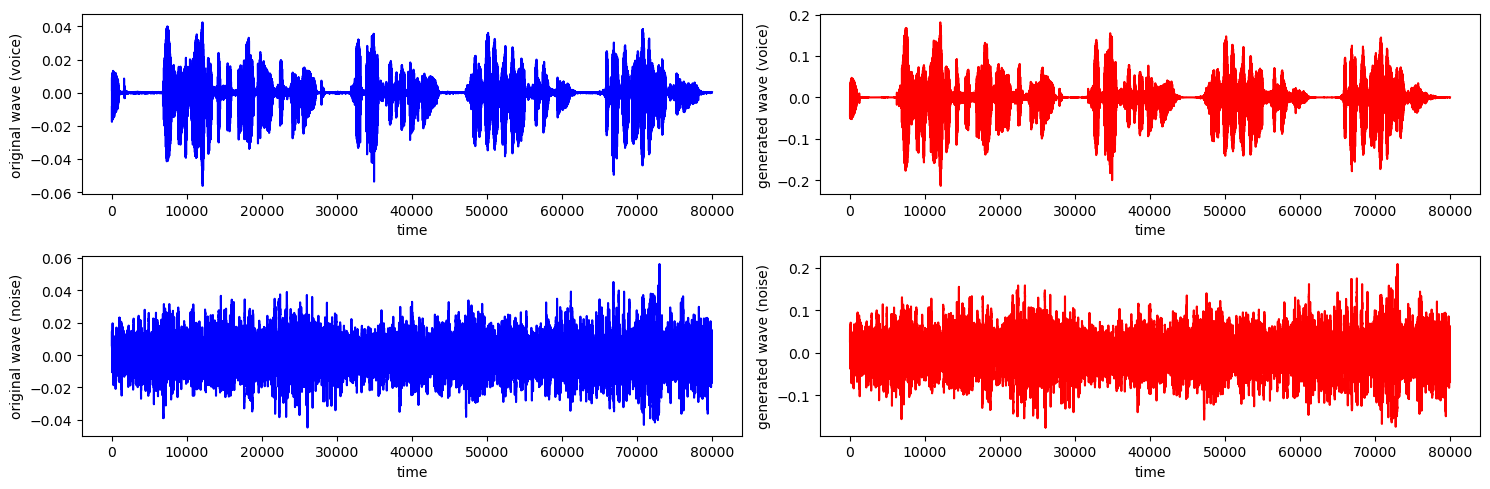

In [123]:
fig, axs = plt.subplots(2, 2, figsize=(15, 5))

axs[0,0].plot(voice_gt.squeeze().numpy(), color='blue')
axs[0,0].set_xlabel('time')
axs[0,0].set_ylabel('original wave (voice)')

axs[0,1].plot(voice_est.squeeze().numpy(), color='red')
axs[0,1].set_xlabel('time')
axs[0,1].set_ylabel('generated wave (voice)')


axs[1,0].plot(noise_gt.squeeze().numpy(), color='blue')
axs[1,0].set_xlabel('time')
axs[1,0].set_ylabel('original wave (noise)')

axs[1,1].plot(noise_est.squeeze().numpy(), color='red')
axs[1,1].set_xlabel('time')
axs[1,1].set_ylabel('generated wave (noise)')
plt.savefig('Figs/UNet2_wave.png')
plt.tight_layout()

*Comparaison selon le snr de base :*

In [126]:
metrics_dir2 = "Scores/UNet2/"

metrics_by_snr2 = {}

# Liste des SNR et des signaux que vous avez enregistrés
snr_values = np.arange(-4,5)  
signals = ['voice', 'noise']  

# Lire les fichiers CSV pour chaque combinaison SNR et Signal
for snr in snr_values:
    metrics_by_snr2[snr] = {}  
    for signal in signals:
        # Construire le chemin du fichier correspondant pour ce signal et SNR
        file_path = os.path.join(metrics_dir, f'val_metrics_SNR_{snr}_{signal}.csv')
        if os.path.exists(file_path):
            #print(file_path)
            # Lire le fichier CSV dans un DataFrame
            df = pd.read_csv(file_path)
            
            # Stocker les métriques pour ce signal et SNR
            metrics_by_snr2[snr][signal] = df

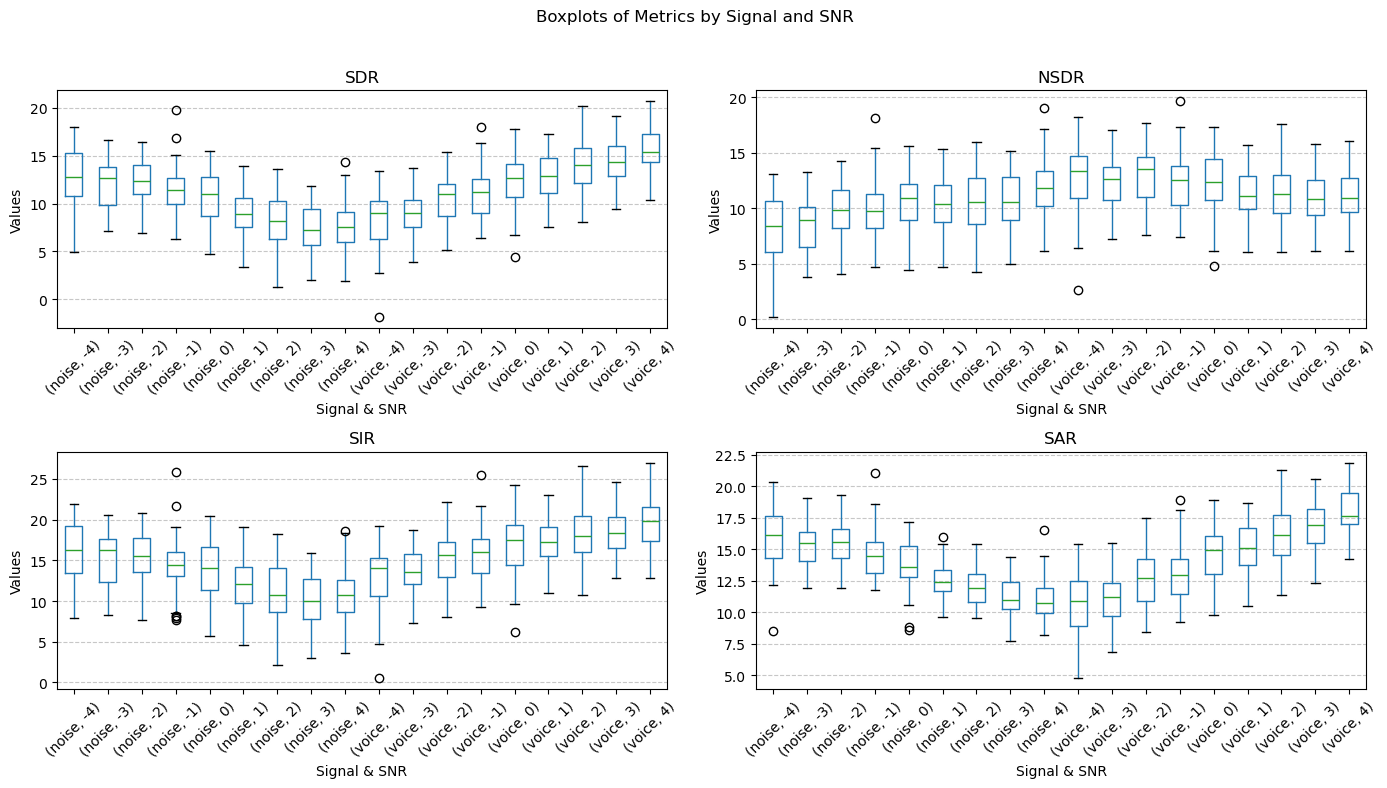

In [128]:
# Combiner les données pour chaque signal et SNR
all_data = []
for snr, metrics in metrics_by_snr2.items():
    for signal, df in metrics.items():
        df['SNR'] = snr
        df['Signal'] = signal
        all_data.append(df)

# Créer un DataFrame combiné
combined_df = pd.concat(all_data, ignore_index=True)

# Tracer les boxplots pour chaque métrique
metrics = ['SDR', 'NSDR', 'SIR', 'SAR']
plt.figure(figsize=(14, 8))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    combined_df.boxplot(column=metric, by=['Signal', 'SNR'], grid=False, ax=plt.gca())
    plt.title(metric)
    plt.xlabel('Signal & SNR')
    plt.ylabel('Values')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajouter un titre principal et ajuster la mise en page
plt.suptitle('Boxplots of Metrics by Signal and SNR')
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Sauvegarder le graphique
output_path = 'Figs/UNet2_val_metrics.png'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path)

# Afficher le graphique
plt.show()

___
### 4. WaveUNet

On se concentre dans cette partie sur l'implémentation d'un modèle génératif basé directement sur la forme d'onde sans passer sur la représentation temps/fréquence de la magnitude du signal.
On implémente le modèle dans des conditions similaires à celles décrites par *Stoller et al. (2018) https://arxiv.org/pdf/1806.03185*

L'architecture est un UNet sur la forme d'onde (structure encodeur/decodeur), composé de 12 layers d'encoding vers un espace de dimension réduit et 12 layers de upsampling pour retrouver le signal original masqué sur les composantes de bruit et de voix. Chaque étape de upsampling est contextualisé par une copie de l'état de downsampling à la même étape. Contrairement à un UNet classique, les auteurs proposent deux différences sur les méthodes de downsampling et de upsampling : 
- Les encodeurs réduisent la taille du signal d'entrée par décimation en supprimant de moitié les valeurs retenues de l'étape précédente
- les décodeurs réalisent un upsampling par interpolation linéaire au lieu de convolutions transposées, afin d'obtenir un meilleur lissage du signal et limiter l'apparition d'artefacts

Dans notre cas on décide de rééchantilloner le signal avec 65536 points au total sur les dix secondes d'audio (downsample avec taille en puissance de 2 pour simplifier le calcul des dimensions de convolution)

In [131]:
from Models.WaveUNet import *

N_POINTS = 65536

*Taille du modèle estimé (en nombre de paramètres) : ~ 10.26M*

In [134]:
model = WaveUNet().to(device)
print(np.sum([p.numel() for p in model.parameters()]))

10263028


*Détail des dimensions sur les couches du réseau de neurones :*

In [137]:
summary(model, input_size=(1, 65536))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 24, 65536]             384
         LeakyReLU-2            [-1, 24, 65536]               0
       Downsampler-3            [-1, 24, 65536]               0
            Conv1d-4            [-1, 48, 32768]          17,328
         LeakyReLU-5            [-1, 48, 32768]               0
       Downsampler-6            [-1, 48, 32768]               0
            Conv1d-7            [-1, 72, 16384]          51,912
         LeakyReLU-8            [-1, 72, 16384]               0
       Downsampler-9            [-1, 72, 16384]               0
           Conv1d-10             [-1, 96, 8192]         103,776
        LeakyReLU-11             [-1, 96, 8192]               0
      Downsampler-12             [-1, 96, 8192]               0
           Conv1d-13            [-1, 120, 4096]         172,920
        LeakyReLU-14            [-1, 12

*Chargement des données pour WaveUNet :*

In [140]:
train_dataset = Audiodataset('train', resample_n_points=N_POINTS, getitem='concatVN')
train_dataset.take_wave()

test_dataset = Audiodataset('test', resample_n_points=N_POINTS, getitem='concatVN')
test_dataset.take_wave()

On utilise un batch size de 16 seulement (haute demande en ressources mémoires durant les étapes de downsampling) et un learning rate initial de 0.0001 pour l'optimiseur Adam comme décris dans l'article pour le modèle baseline :

In [143]:
# ==== Entrainement ====
# model, losses = WaveUNet.trainModel(train_dataset, n_epochs=20, batch_size=16, learning_rate=0.001, valid_dataset=test_dataset)

*Evolution de la loss (MSE error) :*

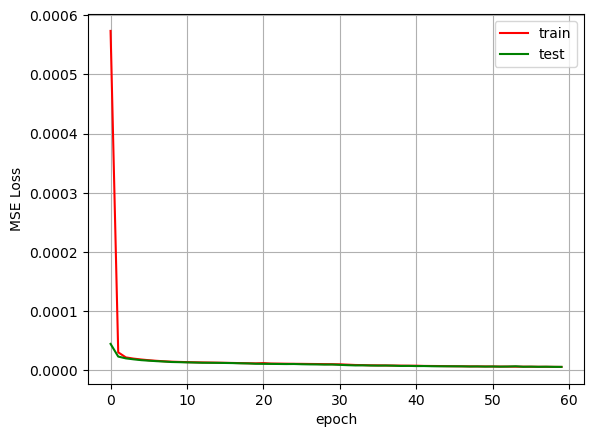

In [146]:
scores_WaveUNet = pd.read_csv('Scores/WaveUNet/WaveUNetMSE.csv')
train_error = scores_WaveUNet['train']
valid_error = scores_WaveUNet['valid']

plt.plot(train_error, color='red', label='train')
plt.plot(valid_error, color='green', label='test')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MSE Loss')
plt.savefig('Figs/WaveUNetLoss.png')

*Ecoute sur une donnée test :*

In [149]:
idx = 0

In [151]:
X, Y = test_dataset[idx]
model = WaveUNet()
model.load_state_dict(torch.load('Paths/WaveUNet/model_40.pth'))
output = model(X.unsqueeze(0))

*Comparaison Voix originale/Voix générée :*

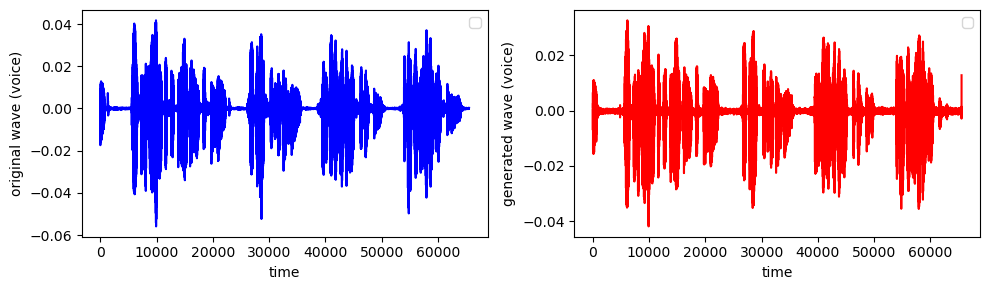

In [153]:
Vtrue = Y[0,:].squeeze().detach().numpy()
Vpred = output[:,0,:].squeeze().detach().numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(Vtrue, color='blue')
axs[0].legend()
axs[0].set_xlabel('time')
axs[0].set_ylabel('original wave (voice)')

axs[1].plot(Vpred, color='red')
axs[1].legend()
axs[1].set_xlabel('time')
axs[1].set_ylabel('generated wave (voice)')

plt.tight_layout()
plt.savefig('Figs/WaveUNetVoiceEx.png')

*Comparaison Bruit original/Bruit généré :*

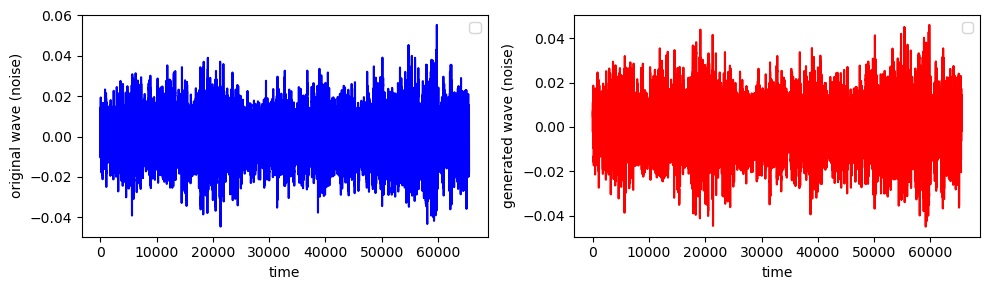

In [156]:
Ntrue = Y[1,:].squeeze().detach().numpy()
Npred = output[:,1,:].squeeze().detach().numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(Ntrue, color='blue')
axs[0].legend()
axs[0].set_xlabel('time')
axs[0].set_ylabel('original wave (noise)')

axs[1].plot(Npred, color='red')
axs[1].legend()
axs[1].set_xlabel('time')
axs[1].set_ylabel('generated wave (noise)')

plt.tight_layout()
plt.savefig('Figs/WaveUNetNoiseEx.png')

*Ecoute du son original (bruité)/voix originale/voix générée/bruit original/bruit généré :*

In [159]:
# son original
IPython.display.Audio(X.squeeze().detach().numpy(), rate=N_POINTS/10)

In [161]:
# voix originale
IPython.display.Audio(Vtrue, rate=N_POINTS/10)

In [163]:
# voix générée (extraite du son original)
IPython.display.Audio(Vpred, rate=N_POINTS/10)

In [165]:
# bruit original
IPython.display.Audio(Ntrue, rate=N_POINTS/10)

In [167]:
# bruit généré (extrait du son original)
IPython.display.Audio(Npred, rate=N_POINTS/10)

*SNR estimé à partir du bruit résiduel :*

In [170]:
model.eval()
model.to(device)

SNRV = []
SNRN = []

criterion = torch.nn.MSELoss()

for snr in tqdm(range(-4, 5)):

    test_dataset = Audiodataset('test', resample_n_points=N_POINTS, snr_filter=snr, getitem='concatVN')
    test_dataset.take_wave()    
    test_dataloader = DataLoader(test_dataset, batch_size=16)

    numsV = 0.0
    denomsV = 0.0
    numsN = 0.0
    denomsN = 0.0

    for X, Y in test_dataloader:

        X, Y = X.to(device), Y.to(device)
        output = model(X)
        
        Vpred = output[:,0,:]
        Npred = output[:,1,:]
        
        numsV += torch.sum((Y[:,0,:]**2).squeeze()).item()
        denomsV += torch.sum( ((Y[:,0,:] - Vpred)**2).squeeze() ).item()

        numsN += torch.sum((Y[:,1,:]**2).squeeze()).item()
        denomsN += torch.sum( ((Y[:,1,:] - Npred)**2).squeeze() ).item()

    SNRV.append(10*np.log10(numsV/denomsV))
    SNRN.append(10*np.log10(numsN/denomsN))

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:35<00:00,  3.90s/it]


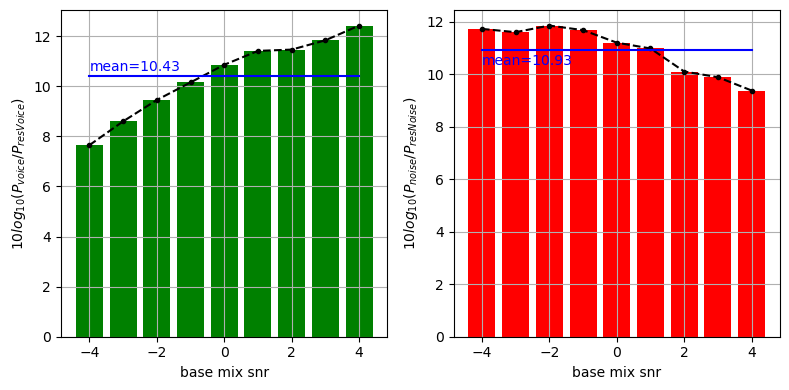

In [172]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

ax = axs[0]
ax.bar(range(-4, 5), SNRV, color='green')
ax.plot(range(-4, 5), SNRV, color='black', marker='.', linestyle='--')
ax.plot([-4, 4], [np.mean(SNRV), np.mean(SNRV)], color='blue')
ax.text(-4, np.mean(SNRV)+0.2, f'mean={np.mean(SNRV):.2f}', color='blue')
ax.grid()
ax.set_ylabel('$10log_{10}(P_{voice}/P_{resVoice})$')
ax.set_xlabel('base mix snr')

ax = axs[1]
ax.bar(range(-4, 5), SNRN, color='red')
ax.plot(range(-4, 5), SNRN, color='black', marker='.', linestyle='--')
ax.plot([-4, 4], [np.mean(SNRN), np.mean(SNRN)], color='blue')
ax.text(-4, np.mean(SNRN)-0.6, f'mean={np.mean(SNRN):.2f}', color='blue')
ax.grid()
ax.set_ylabel('$10log_{10}(P_{noise}/P_{resNoise})$')
ax.set_xlabel('base mix snr')

plt.tight_layout()
plt.savefig('Figs/WaveUNetSNR.png')

___
### 5. Conv-TasNet

Le dernier modèle implémenté est un encodeur/décodeur réalisant des convolutions succesives avec dilatation dans l'espace des features pour augmenter la capture de relations temporelles. Contrairement au WaveUNet, le modèle apprend à générer un masque qui est appliqué dans l'espace latent avant l'étape de decoding. Les entrées et sorties sont, comme pour le WaveUnet, fournies sous la forme d'onde ce qui permet d'éviter la reconstruction du signal depuis la représentation temps/fréquence.

Pour ce modèle nous reprenons une sélection d'hyperparamètres affichant les meilleurs résultats empiriques obtenus par *Yi Luo et al.* https://arxiv.org/pdf/1809.07454 (2019)

*Modèle et descritpion des dimensions des couches du réseau :*

In [176]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ConvTasNet(2).to(device)

In [178]:
summary(model, input_size=(1, 80000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 256, 5002]           8,192
         GroupNorm-2            [-1, 256, 5002]             512
            Conv1d-3             [-1, 64, 5002]          16,448
            Conv1d-4            [-1, 256, 5002]          16,640
             PReLU-5            [-1, 256, 5002]               1
         GroupNorm-6            [-1, 256, 5002]             512
            Conv1d-7            [-1, 256, 5002]         196,864
             PReLU-8            [-1, 256, 5002]               1
         GroupNorm-9            [-1, 256, 5002]             512
           Conv1d-10             [-1, 64, 5002]          16,448
           Conv1d-11             [-1, 64, 5002]          16,448
              C1D-12  [[-1, 64, 5002], [-1, 64, 5002]]               0
           Conv1d-13            [-1, 256, 5002]          16,640
            PReLU-14            

*Nombre de paramètres du modèles :~3.04M*

In [181]:
np.sum([p.numel() for p in model.parameters()])

3035737

*Données d'entrainement :*

In [184]:
train_dataset = Audiodataset('train', getitem='concatVN')
train_dataset.take_wave()

test_dataset = Audiodataset('test', getitem='concatVN')
test_dataset.take_wave()

*Entrainement :*

In [186]:
# ==== Entrainement ====
# model, losses = ConvTasNet.trainModel(train_dataset, 10, batch_size=16, valid_dataset=test_dataset)

*Fonction de perte :*

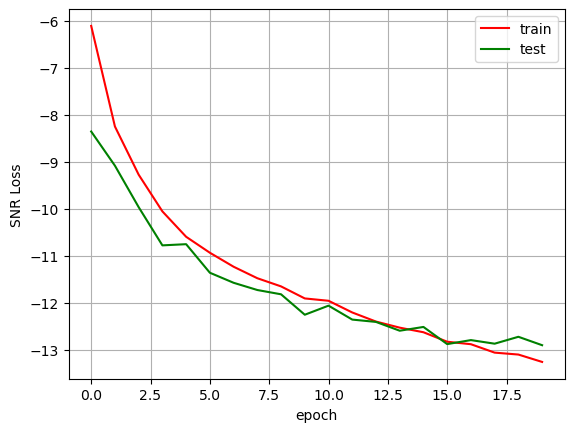

In [189]:
scores_WaveUNet = pd.read_csv('Scores/TasNet/TasNetSNRLoss.csv')
train_error = scores_WaveUNet['train']
valid_error = scores_WaveUNet['valid']

plt.plot(train_error, color='red', label='train')
plt.plot(valid_error, color='green', label='test')
plt.grid()
plt.legend()
plt.xlabel('epoch')

plt.ylabel('SNR Loss')
plt.savefig('Figs/TasNetSNRLoss.png')

*Comparaison des signaux sur une donnée test :*

In [196]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ConvTasNet(2).to(device)
model.load_state_dict(torch.load("Paths/TasNet/model_20.pth"))

<All keys matched successfully>

In [198]:
idx = 0
X, Y = test_dataset[idx]
output = model(X.to(device).unsqueeze(0))

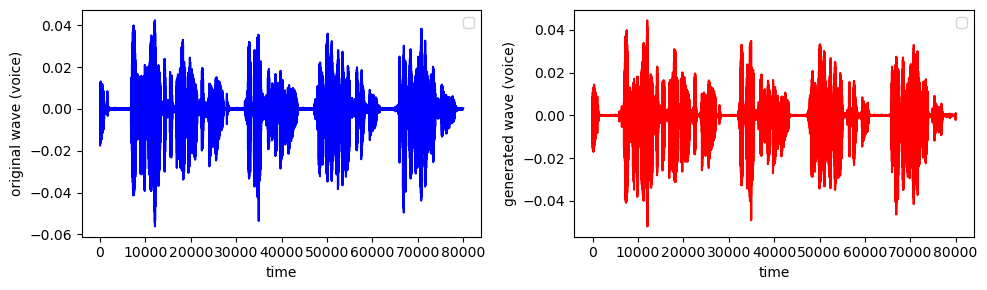

In [200]:
Vtrue = Y[0,:].squeeze().cpu().detach().numpy()
Vpred = output[:,0,:].squeeze().cpu().detach().numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(Vtrue, color='blue')
axs[0].legend()
axs[0].set_xlabel('time')
axs[0].set_ylabel('original wave (voice)')

axs[1].plot(Vpred, color='red')
axs[1].legend()
axs[1].set_xlabel('time')
axs[1].set_ylabel('generated wave (voice)')

plt.tight_layout()
plt.savefig('Figs/TasNet.png')

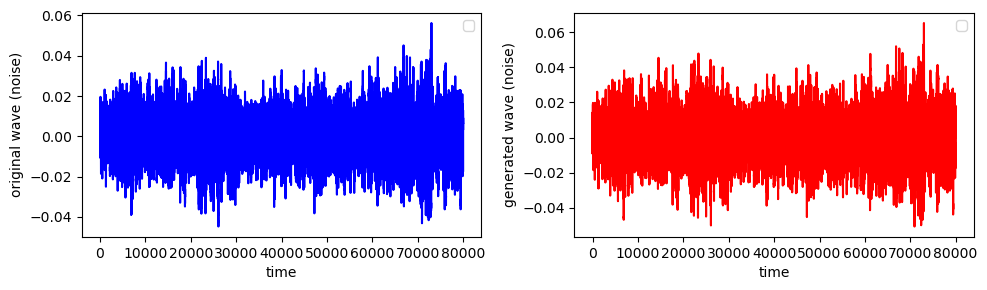

In [202]:
Ntrue = Y[1,:].squeeze().cpu().detach().numpy()
Npred = output[:,1,:].squeeze().cpu().detach().numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(Ntrue, color='blue')
axs[0].legend()
axs[0].set_xlabel('time')
axs[0].set_ylabel('original wave (noise)')

axs[1].plot(Npred, color='red')
axs[1].legend()
axs[1].set_xlabel('time')
axs[1].set_ylabel('generated wave (noise)')

plt.tight_layout()
plt.savefig('Figs/WaveUNetNoiseEx.png')

*Ecoute qualitative :*

In [205]:
# son original
IPython.display.Audio(X.squeeze().detach().numpy(), rate=8000)

In [207]:
# voix originale
IPython.display.Audio(Vtrue, rate=8000)

In [209]:
# voix générée (extraite du son original)
IPython.display.Audio(Vpred, rate=8000)

In [211]:
# bruit original
IPython.display.Audio(Ntrue, rate=8000)

In [213]:
# bruit généré (extrait du son original)
IPython.display.Audio(Npred, rate=8000)

*Evaluation du SNR :*

In [216]:
model.eval()
model.to(device)

SNRV = []
SNRN = []

for snr in tqdm(range(-4, 5)):

    test_dataset = Audiodataset('test', snr_filter=snr, getitem='concatVN')
    test_dataset.take_wave()    
    test_dataloader = DataLoader(test_dataset, batch_size=16)

    numsV = 0.0
    denomsV = 0.0
    numsN = 0.0
    denomsN = 0.0

    for X, Y in test_dataloader:

        X, Y = X.to(device), Y.to(device)
        output = model(X)
        
        Vpred = output[:,0,:]
        Npred = output[:,1,:]
        
        numsV += torch.sum((Y[:,0,:]**2).squeeze()).item()
        denomsV += torch.sum( ((Y[:,0,:] - Vpred)**2).squeeze() ).item()

        numsN += torch.sum((Y[:,1,:]**2).squeeze()).item()
        denomsN += torch.sum( ((Y[:,1,:] - Npred)**2).squeeze() ).item()

    SNRV.append(10*np.log10(numsV/denomsV))
    SNRN.append(10*np.log10(numsN/denomsN))

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:28<00:00,  9.81s/it]


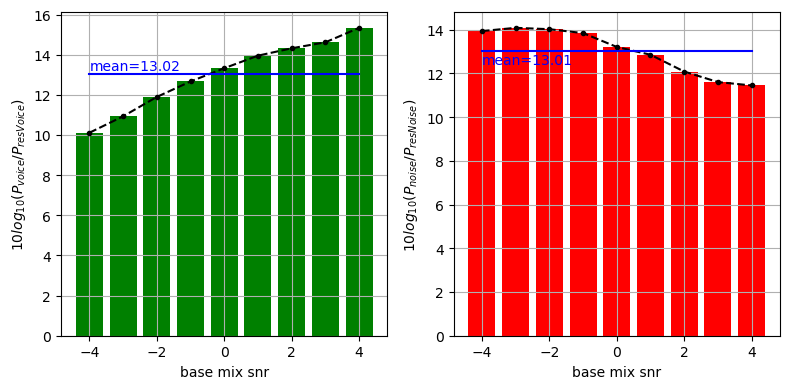

In [218]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

ax = axs[0]
ax.bar(range(-4, 5), SNRV, color='green')
ax.plot(range(-4, 5), SNRV, color='black', marker='.', linestyle='--')
ax.plot([-4, 4], [np.mean(SNRV), np.mean(SNRV)], color='blue')
ax.text(-4, np.mean(SNRV)+0.2, f'mean={np.mean(SNRV):.2f}', color='blue')
ax.grid()
ax.set_ylabel('$10log_{10}(P_{voice}/P_{resVoice})$')
ax.set_xlabel('base mix snr')

ax = axs[1]
ax.bar(range(-4, 5), SNRN, color='red')
ax.plot(range(-4, 5), SNRN, color='black', marker='.', linestyle='--')
ax.plot([-4, 4], [np.mean(SNRN), np.mean(SNRN)], color='blue')
ax.text(-4, np.mean(SNRN)-0.6, f'mean={np.mean(SNRN):.2f}', color='blue')
ax.grid()
ax.set_ylabel('$10log_{10}(P_{noise}/P_{resNoise})$')
ax.set_xlabel('base mix snr')

plt.tight_layout()
plt.savefig('Figs/WaveUNetSNR.png')